# **Verify that you're running in a capable GPU-enabled environment**

Ensure that your environment is GPU-enabled and has at least 16GB RAM.


In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader
!nvidia-smi

# **Restart runtime**


In [ ]:
#@markdown ### Kill switch

#@markdown If your GPU needs to be cleared, run this script to crash & restart the runtime.

def kill():
  from os import kill, getpid
  kill(getpid(), 9) # This will crash Colab (run when runtime needs reset)

kill()

# **Initialize environment**

In this section, you will setup your environment to run the training.

## **Install requirements**

In [ ]:
def changeDirectory(p):
  from os import chdir
  chdir(p)

def createDirectory(p):
    try:
        from os import makedirs
        makedirs(p)
        print(f"Directory '{p}' created")
    except OSError as e:
        print(f"Directory '{p}' already exists")

def mountGdriveIfNotMounted():
    if not exists('/content/drive'):
        from google.colab import drive
        drive.mount('/content/drive')
        print("Gdrive mounted")

def normalizePath(p, useGdrive=False):
    from os import makedirs
    if useGdrive:
        mountGdriveIfNotMounted()
        path = "/content/drive/MyDrive/" + p
    else:
        path = "/content/" + p
    createDirectory(path);
    return path;

def sys(c, logOutput = False):
    from subprocess import run, PIPE
    p = run(c, shell=True, stdout=PIPE, stderr=PIPE)
    output = p.stdout.decode()
    errors = p.stderr.decode()
    if logOutput :
        print(output)
    if errors != "" :
        print(errors)

def exists(p):
    from os import path
    return path.exists(p)

def isEmpty(p):
    from os import listdir
    return len(listdir(p)) == 0

def cloneRepo(server, name, destination):
    changeDirectory("/content")
    repo = f"{server}/{name}"
    command = f"git clone https://{repo}.git"
    if destination != "":
        sys(command  +" "+ destination)
    else:
        sys(command)
    print(f"Repo '{repo}' cloned to '{destination}'")
    changeDirectory("/content")

def updateRepo(server, name, destination):
    changeDirectory(destination)
    sys("git pull")
    print(f"Repo {server}/{name} in directory {destination} updated")
    changeDirectory("/content")

def clearDirectory(destination):
    sys(f"rm -f -r {destination}")
    print(f"Directory {destination} deleted")
    changeDirectory("/content")

def pipInstall(parameters):
    sys(f"pip install {parameters}")
    print(f"'pip install' completed with parameters '{parameters}'")

#@markdown ### Repo

#@markdown Which repo do you want to use

REPO_SERVER = "github.com" #@param ["github.com"]

REPO = "ShivamShrirao/diffusers" #@param ["jslegers/diffusers", "ShivamShrirao/diffusers", "huggingface/diffusers"]

#@markdown Where to install

INSTALL_REPO_ON_GDRIVE = False #@param {type:"boolean"}

INSTALLATION_PATH = "diffusers" #@param {type:"string"}
INSTALLATION_PATH = normalizePath(INSTALLATION_PATH, INSTALL_REPO_ON_GDRIVE)

IF_DIRECTORY_NOT_EMPTY = "Reinstall" #@param ["Update", "Reinstall", "Do nothing"]

if exists(INSTALLATION_PATH) and not isEmpty(INSTALLATION_PATH):
    if IF_DIRECTORY_NOT_EMPTY == "Update":
        updateRepo(REPO_SERVER, REPO, INSTALLATION_PATH)
    elif IF_DIRECTORY_NOT_EMPTY == "Reinstall":
        clearDirectory(INSTALLATION_PATH)
        cloneRepo(REPO_SERVER, REPO, INSTALLATION_PATH)
else:
    cloneRepo(REPO_SERVER, REPO, INSTALLATION_PATH)
pipInstall(f"git+file:{INSTALLATION_PATH}")

pipInstall("-q -U --pre triton")
pipInstall("-q accelerate==0.12.0 transformers ftfy bitsandbytes gradio")

#@markdown ### Wheels

#@markdown Where compiled on Tesla T4, but should also work on P100, thanks to https://github.com/brian6091

#@markdown If precompiled wheels don't work, uncheck this flag.

#@markdown If not using precompoled wheels, wheels will take around 40 minutes to compile.

USE_PRECOMPILED_WHEELS = True #@param {type:"boolean"}

if USE_PRECOMPILED_WHEELS:
    pipInstall("-q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl")
else:
    pipInstall("git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers")


Directory '/content/diffusers' created
Cloning into '/content/diffusers'...

Repo 'github.com/ShivamShrirao/diffusers' cloned to '/content/diffusers'
  Running command git clone -q file:///content/diffusers /tmp/pip-req-build-duqab7rf

'pip install' completed with parameters 'git+file:/content/diffusers'
'pip install' completed with parameters '-q -U --pre triton'
'pip install' completed with parameters '-q accelerate==0.12.0 transformers ftfy bitsandbytes gradio'
'pip install' completed with parameters '-q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl'


## **Login to HF**

In [ ]:
#@markdown ### Login to HuggingFace

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights.

#@markdown Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in Hugging Face Hub, and you'll also need to use an access token for the code to work.

def sys(c, logOutput = False):
    from subprocess import run, PIPE
    p = run(c, shell=True, stdout=PIPE, stderr=PIPE)
    output = p.stdout.decode()
    errors = p.stderr.decode()
    if logOutput :
        print(output)
    if errors != "" :
        print(errors)

def loginToHuggingFace():
    from huggingface_hub import notebook_login
    sys('git config --global credential.helper store')
    notebook_login()

loginToHuggingFace()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## **Configuration**

In [ ]:
def exists(p):
    from os import path
    return path.exists(p)
    
def createDirectory(p):
    try:
        from os import makedirs
        makedirs(p)
        print(f"Directory '{p}' created")
    except OSError as e:
        print(f"Directory '{p}' already exists")

def mountGdriveIfNotMounted():
    if not exists('/content/drive'):
        from google.colab import drive
        drive.mount('/content/drive')
        print("Gdrive mounted")

def normalizePath(p, useGdrive=False):
    from os import makedirs
    if useGdrive:
        mountGdriveIfNotMounted()
        path = "/content/drive/MyDrive/" + p
    else:
        path = "/content/" + p
    createDirectory(path);
    return path;

#@markdown ### Name/Path of the initial model

LOAD_FROM = "Repo" #@param ["Repo", "GDrive", "Runtime"]

INITIAL_MODEL = "johnslegers/dreamlike" #@param {type:"string"}

PRETRAINED_VAE = "" #@param {type:"string"}

if INITIAL_MODEL:
    if LOAD_FROM == "GDrive":
        INITIAL_MODEL = normalizePath(INITIAL_MODEL, True)
    elif LOAD_FROM == "Runtime":
        INITIAL_MODEL = normalizePath(INITIAL_MODEL, False)

#@markdown ### The identifier you want to use for the concept you'll be training
#@markdown This should be a rare identifier, so the ID doesn't confuse it for something else

CONCEPT = "midjourney" #@param {type:"string"}

#@markdown ### A general name for class 

#@markdown For example, use "dog" for dog images, "man" for images of a male human, etc.

CLASS_NAME = "style" #@param {type:"string"}

#@markdown ### Path where you want to store class images

LOAD_CLASS_IMAGES_FROM_GDRIVE = True #@param {type:"boolean"}

ONLY_GENERATE_CLASS_IMAGES_IF_DIRECTORY_IS_EMPTY = True #@param {type:"boolean"}

CLASS_DIR = "stable_diffusion/trainingimages/style" #@param {type:"string"}
if CLASS_DIR:
    CLASS_DIR = normalizePath(CLASS_DIR, LOAD_CLASS_IMAGES_FROM_GDRIVE)

#@markdown ### Path for images of the concept for training

LOAD_CONCEPT_IMAGES_FROM_GDRIVE = True #@param {type:"boolean"}

INPUT_DIR = "stable_diffusion/trainingimages/midjourney" #@param {type:"string"}
if INPUT_DIR:
    INPUT_DIR = normalizePath(INPUT_DIR, LOAD_CONCEPT_IMAGES_FROM_GDRIVE)

#@markdown ### Path where the trained model will be saved

SAVE_CONCEPT_IMAGES_TO_GDRIVE = True #@param {type:"boolean"}

OUTPUT_DIR = "" #@param {type:"string"}
if OUTPUT_DIR:
    OUTPUT_DIR = normalizePath(OUTPUT_DIR, SAVE_CONCEPT_IMAGES_TO_GDRIVE)

#@markdown ### If model weights should be saved as a concept on the Huggingface website
#@markdown Once you save it you can use your concept by loading the model on any `from_pretrained` function

SAVE_TO_HUGGINGFACE = False #@param {type:"boolean"}

NAME_OF_YOUR_CONCEPT = "js-man" #@param {type:"string"}
WHERE_TO_SAVE_YOUR_CONCEPT = "privately_to_my_profile" #@param ["public_library", "privately_to_my_profile"]

#@markdown Leave `hf_token_write` blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf).

#@markdown If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)

HF_TOKEN_WRITE = "" #@param {type:"string"}

print(f"[*] Concept is '{CONCEPT}'")
print(f"[*] Class name is '{CLASS_NAME}'")
print(f"[*] Initial model will be loaded from '{INITIAL_MODEL}'")
print(f"[*] Class images will be loaded from '{CLASS_DIR}'")
print(f"[*] Concept images will be loaded from '{INPUT_DIR}'")
print(f"[*] Trained model will be saved at '{OUTPUT_DIR}'")
if SAVE_TO_HUGGINGFACE :
    print(f"[*] Trained model will be also saved at Huggingface as '{NAME_OF_YOUR_CONCEPT}'")


Mounted at /content/drive
Gdrive mounted
Directory '/content/drive/MyDrive/stable_diffusion/trainingimages/style' already exists
Directory '/content/drive/MyDrive/stable_diffusion/trainingimages/midjourney' already exists
[*] Concept is 'midjourney'
[*] Class name is 'style'
[*] Initial model will be loaded from 'johnslegers/dreamlike'
[*] Class images will be loaded from '/content/drive/MyDrive/stable_diffusion/trainingimages/style'
[*] Concept images will be loaded from '/content/drive/MyDrive/stable_diffusion/trainingimages/midjourney'
[*] Trained model will be saved at ''


## **Advanced configuration**

In [ ]:
#@markdown ### Prompt with identifier specifing the instance
#@markdown If empty, the trainer will use the concept name 

INSTANCE_PROMPT = "the style of midjourney" #@param {type:"string"}

#@markdown ### Prompt with identifier specifing the class
#@markdown If empty, the trainer will use the class name 

CLASS_PROMPT = "a style" #@param {type:"string"}

#@markdown ### Flag to add prior perservation loss 

WITH_PRIOR_PRESERVATION = True #@param {type:"boolean"}

#@markdown ### The weight of prior preservation loss

PRIOR_LOSS_WEIGHT = 1.0 #@param {type:"number"}

#@markdown ### Minimal class images for prior perversation loss
#@markdown If not have enough images, additional images will be sampled with class_prompt

NUM_CLASS_IMAGES = 912 #@param {type:"integer"}

#@markdown ### A seed for reproducible training

SEED = -1 #@param {type:"integer"}

#@markdown ### The resolution for input images
#@markdown All the images in the train/validation dataset will be resized to this

RESOLUTION = 512 #@param {type:"integer"}

#@markdown ### Whether to center crop images before resizing to resolution

CENTER_CROP = False #@param {type:"boolean"}

#@markdown ### Batch size (per device) for the training dataloader

TRAIN_BATCH_SIZE = 1 #@param {type:"integer"}

#@markdown ### Batch size (per device) for sampling images

SAMPLE_BATCH_SIZE = 4 #@param {type:"integer"}

#@markdown ### Total number of training epochs to perform

NUM_TRAIN_EPOCHS = 1 #@param {type:"integer"}

#@markdown ### Total number of training steps to perform
#@markdown If provided, overrides `NUM_TRAIN_EPOCHS`

MAX_TRAIN_STEPS = 1100 #@param {type:"integer"}

#@markdown ### Number of updates steps to accumulate before performing a backward/update pass

GRADIENT_ACCUMULATION_STEPS = 1 #@param {type:"integer"}

#@markdown ### Whether or not to use gradient checkpointing
#@markdown This saves memory at the expense of slower backward pass

GRADIENT_CHECKPOINTING = True #@param {type:"boolean"}

#@markdown ### Initial learning rate (after the potential warmup period) to use

LEARNING_RATE = 1e-6 #@param {type:"number"}

#@markdown ### Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size

SCALE_LR = False #@param {type:"boolean"}

#@markdown ### The scheduler type to use

LR_SCHEDULER = "linear" #@param ["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"]

#@markdown ### Number of steps for the warmup in the lr scheduler

LR_WARMUP_STEPS = 0 #@param {type:"integer"}

#@markdown ### Whether or not to use 8-bit Adam from bitsandbytes

USE_8BIT_ADAM = True #@param {type:"boolean"}

#@markdown ### The beta1 parameter for the Adam optimizer

ADAM_BETA1 = 0.9 #@param {type:"number"}

#@markdown ### The beta2 parameter for the Adam optimizer

ADAM_BETA2 = 0.999 #@param {type:"number"}

#@markdown ### Weight decay to use

ADAM_WEIGHT_DECAY = 1e-2 #@param {type:"number"}

#@markdown ### Epsilon value for the Adam optimizer

ADAM_EPSILON = 1e-08 #@param {type:"number"}

#@markdown ### Max gradient norm

MAX_GRAD_NORM = 1.0 #@param {type:"number"}

#@markdown ### Whether or not to push the model to the Hub

PUSH_TO_HUB = False #@param {type:"boolean"}

#@markdown ### Whether to use authorization token
#@markdown Will use the token generated when running `huggingface-cli login`
#@markdown necessary to use this script with private models

USE_AUTH_TOKEN = True #@param {type:"boolean"}

#@markdown ### The token to use to push to the Model Hub
#@markdown If empty and `USE_AUTH_TOKEN` is `True`, `HUB_TOKEN` will be set to the token you used to log into this notebook with

HUB_TOKEN = "" #@param {type:"string"}

#@markdown ### The name of the repository to keep in sync with the local `OUTPUT_DIR`

HUB_MODEL_ID = "" #@param {type:"string"}

#@markdown ### [TensorBoard](https://www.tensorflow.org/tensorboard) log directory.
#@markdown Defaults to *`OUTPUT_DIR`/runs/**CURRENT_DATETIME_HOSTNAME*** if empty

LOGGING_DIR = "" #@param {type:"string"}

#@markdown ### Whether to use mixed precision
#@markdown Bf16 requires PyTorch >= 1.10 and an Nvidia Ampere GPU.

MIXED_PRECISION = "fp16" #@param ["no", "fp16", "bf16"]

#@markdown ### For distributed training

LOCAL_RANK = 4 #@param {type:"integer"}

# **Start training**

remove `--use_8bit_adam` flag in the cell below if you got more than equal to 18 GB VRAM.

`--mixed_precision="fp16"` uses a little more VRAM for some reason but is 1.5-2x faster on GPUs with tensor cores, change it to `--mixed_precision="no"` if you face out of memory issues.

In [ ]:
#@markdown ### Run script
#@markdown This will run the training script with the configuration you defined

COMMAND = f'''train_dreambooth.py \
  --pretrained_model_name_or_path={INITIAL_MODEL} \
  --instance_data_dir="{INPUT_DIR}" \
  --class_data_dir="{CLASS_DIR}" \
  --instance_prompt="{INSTANCE_PROMPT or CONCEPT}" \
  --class_prompt="{CLASS_PROMPT or CLASS_NAME}" \
{"" if not WITH_PRIOR_PRESERVATION else "--with_prior_preservation "}\
  --prior_loss_weight={PRIOR_LOSS_WEIGHT} \
{"" if SEED == -1 else "--seed="+SEED + " "}\
  --num_class_images={NUM_CLASS_IMAGES} \
  --output_dir="{OUTPUT_DIR}" \
  --resolution={RESOLUTION} \
{"" if not CENTER_CROP else "--center_crop "}\
  --train_batch_size={TRAIN_BATCH_SIZE} \
  --sample_batch_size={SAMPLE_BATCH_SIZE} \
  --num_train_epochs={NUM_TRAIN_EPOCHS} \
  --max_train_steps={MAX_TRAIN_STEPS} \
  --gradient_accumulation_steps={GRADIENT_ACCUMULATION_STEPS} \
{"" if not GRADIENT_CHECKPOINTING else "--gradient_checkpointing "}\
  --learning_rate={LEARNING_RATE} \
{"" if not SCALE_LR else "--scale_lr="+SCALE_LR + " "}\
  --lr_scheduler="{LR_SCHEDULER}" \
  --lr_warmup_steps={LR_WARMUP_STEPS} \
{"" if not USE_8BIT_ADAM else "--use_8bit_adam "}\
  --adam_beta1={ADAM_BETA1} \
  --adam_beta2={ADAM_BETA2} \
  --adam_weight_decay={ADAM_WEIGHT_DECAY} \
  --adam_epsilon={ADAM_EPSILON} \
  --max_grad_norm={MAX_GRAD_NORM} \
{"" if not PUSH_TO_HUB else "--push_to_hub "}\
  --hub_model_id="{HUB_MODEL_ID}" \
  --logging_dir="{"logs" if LOGGING_DIR == "" else LOGGING_DIR}" \
  --mixed_precision="{MIXED_PRECISION}" \
  --local_rank={LOCAL_RANK} \
  --train_text_encoder
'''

print(f"Command launched = '{COMMAND}'")

%cd /content/diffusers/examples/dreambooth
!accelerate launch $COMMAND

# Test the trained model

Below you can test the model you just trained

## Inference

In [ ]:
#@markdown ### Load your model

from diffusers import StableDiffusionPipeline, DDIMScheduler
from diffusers.models import AutoencoderKL
from torch import float16, Generator

if OUTPUT_DIR :
    model_path = OUTPUT_DIR
else:
    model_path = INITIAL_MODEL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema")
# scheduler = DDIMScheduler(
#     beta_start=0.00085, 
#     beta_end=0.012, 
#     beta_schedule="scaled_linear", 
#     clip_sample=False, 
#     set_alpha_to_one=False
# )

print(f"Loading model from {model_path}")
pipe = StableDiffusionPipeline.from_pretrained(
    model_path, 
    use_auth_token=True, 
    torch_dtype=float16,
    safety_checker=None, 
    vae=vae#,
#     scheduler=scheduler
).to("cuda")

g_cuda = Generator(device='cuda')

Seed used: 1991295794


  0%|          | 0/20 [00:00<?, ?it/s]

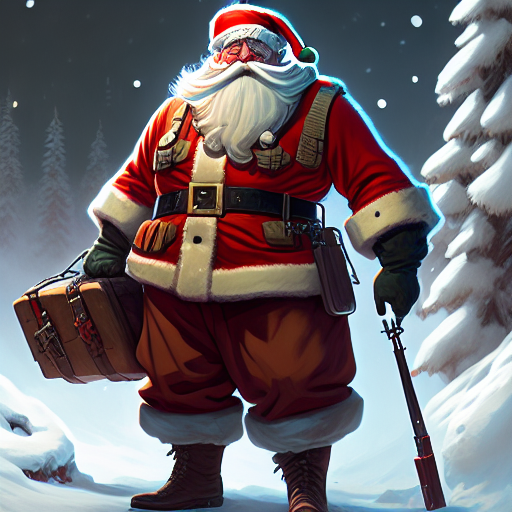

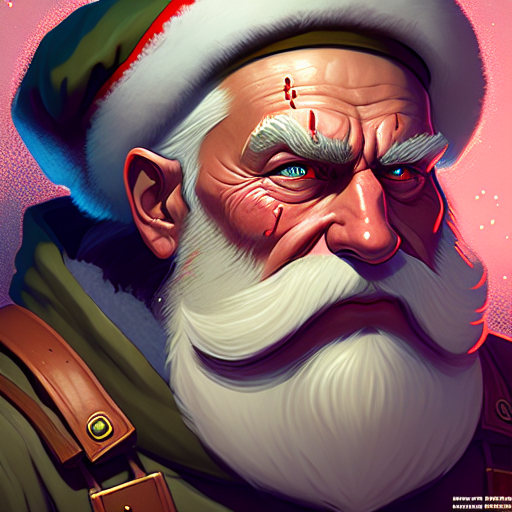

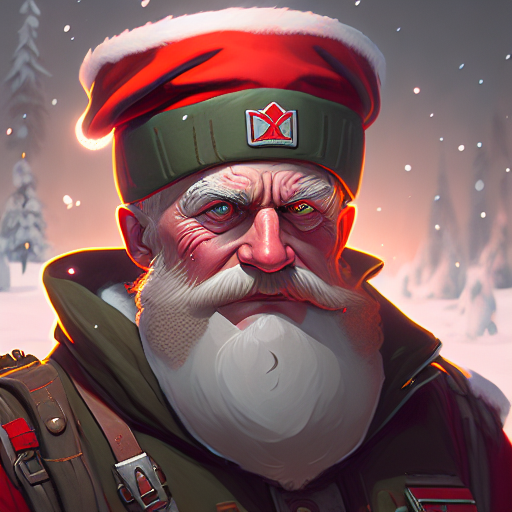

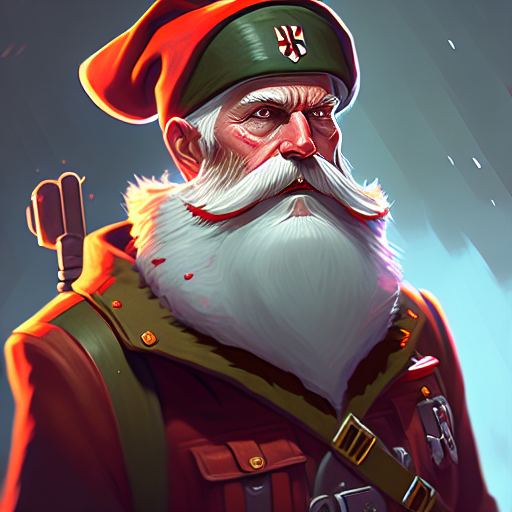

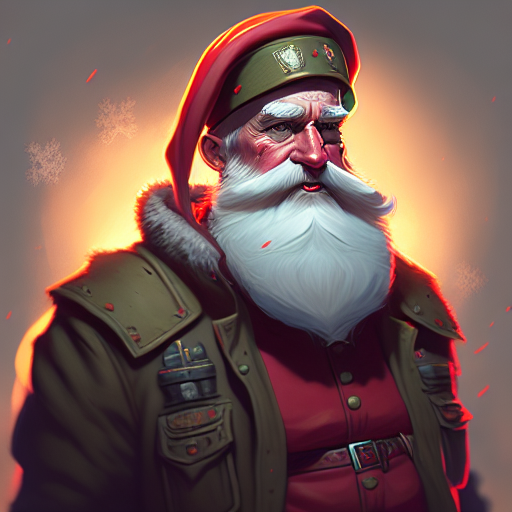

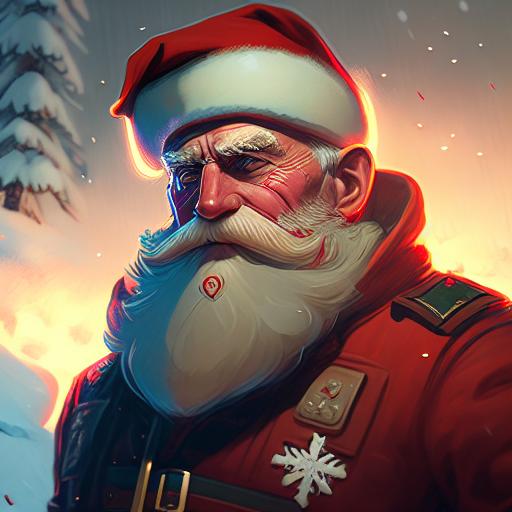

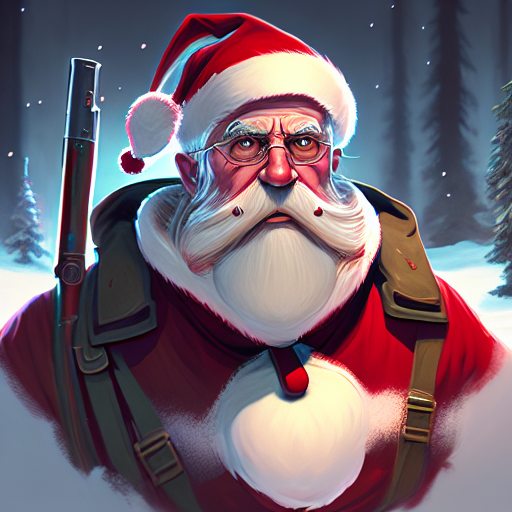

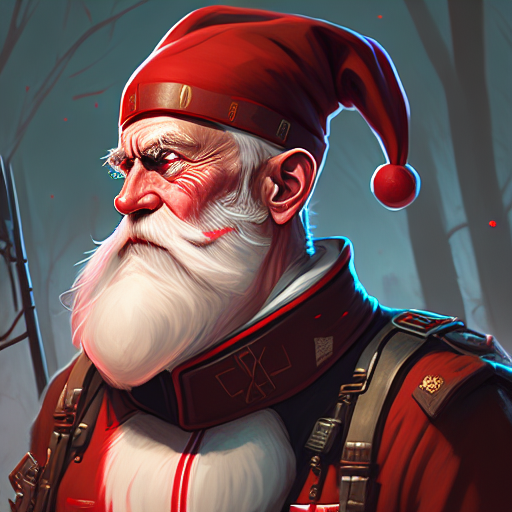

In [ ]:
#@markdown ### Run your model

from torch import autocast, inference_mode
from IPython.display import display

#@markdown Can set random seed here for reproducibility.
seed = 292144198 #@param {type:"integer"}
if(seed and seed > 0):
    g_cuda.manual_seed(seed)
else:
    import random
    seed = random.randint(0,4294967295)
    g_cuda.manual_seed(seed)

#@title Run for generating images.

prompt = "full body portrait of buckaneer santa clause, hyperdetailed portrait, in the style of arcane and fernanda suarez and simon stalenhag and Ilya Kuvshinov and Wlop and Artgerm, trending on artstation, featured on pixiv, dynamic lighting, highly detailed, ambient lighting, octane render, 8k" #@param {type:"string"}
num_samples = 8 #@param {type:"integer"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 20 #@param {type:"integer"}
height = 512 #@param {type:"integer"}
width = 512 #@param {type:"integer"}

print("Seed used: " + str(seed))
with autocast("cuda"), inference_mode():
    images = pipe([prompt] * num_samples, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=g_cuda).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
from torch import autocast, inference_mode
import gradio as gr

model_path = OUTPUT_DIR #If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=float16).to("cuda")

def inference(prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with autocast("cuda"), inference_mode():
        return pipe(
            [prompt]*int(num_samples), height=int(height), width=int(width),
            num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
            generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of johnslegers man, digital painting")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)